
**Необходимо построить минимум 5 визуализации различных видов по выбранным данным, используя хотя бы две из рассмотренных на занятии библиотек.**

Для каждой визуализации описать, какого типа переменные участвуют в визуализации, какова её цель (например, посмотреть на корреляцию двух величин или на распределение значений) и какие гипотезы на ее основе можно выдвинуть

**Откуда брать данные?**

Можно взять свой датасет (тогда не забудьте его выложить на github вместе с ноутбуком) или воспользоваться любым понравившемся из открытых источников (например, [kaggle.com](https://www.kaggle.com/)). Если идей нет, можете взять один из перечисленных ниже:
* [Данные IMDB](https://www.kaggle.com/tmdb/tmdb-movie-metadata/);
* [Данные NYC](https://www.kaggle.com/c/nyc-taxi-trip-duration/);
* [Данные NBA](https://www.kaggle.com/drgilermo/nba-players-stats/).
   

In [43]:
import pandas as pd
import numpy as np
import json
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
#функция с kaggle.com
def load_tmdb_movies(path):
    df = pd.read_csv(path)
    df['release_date'] = pd.to_datetime(df['release_date']).apply(lambda x: x.date())
    json_columns = ['genres', 'keywords', 'production_countries', 'production_companies', 'spoken_languages']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df

#функция с kaggle.com
def load_tmdb_credits(path):
    df = pd.read_csv(path)
    json_columns = ['cast', 'crew']
    for column in json_columns:
        df[column] = df[column].apply(json.loads)
    return df


def get_director(row):
    for crew_member in row['crew']:
        if crew_member["job"]=="Director":
            return crew_member["name"]
    return None   

def normalize(df, columns):
    result = df.copy()
    for feature_name in columns:
#         max_value = df[feature_name].max()
#         min_value = df[feature_name].min()
#         result[feature_name] = (df[feature_name] - min_value) / (max_value - min_value)
        mean_value = df[feature_name].mean()
        std_value = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean_value) / std_value
    return result

def_fig_size = (7,7)


In [35]:
movies = load_tmdb_movies("tmdb_5000_movies.csv")
# print(movies.info())
credits = load_tmdb_credits("tmdb_5000_credits.csv")
# print(credits.info())
credits["director_name"] = credits.apply(get_director, axis = 1)
# credits.head()

### Средний рейтинг и бюджет фильма
- Судя по диаграмме, большой бюджет не является гарантией высокого рейтинга
- Большая часть фильмов имеют рейтинг от 4 до 8, при сравнительно одинаковом бюджете

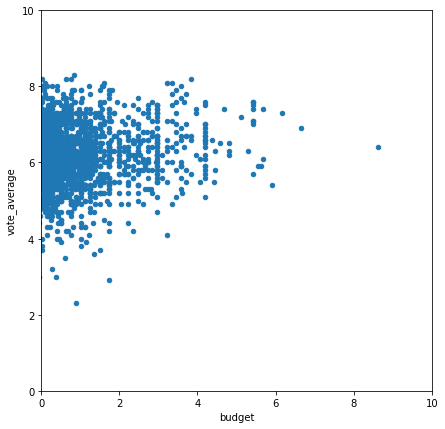

In [40]:
# vote_average vs budget

vote_v_budget = normalize(movies[["id","vote_average","budget"]],["budget"])
# print(vote_v_budget.head())
chart_1_1 = vote_v_budget.plot(y="vote_average", x="budget"
                       , kind="scatter"
                       , figsize = def_fig_size
                       , xlim=(0,max(vote_v_budget["vote_average"].max(),vote_v_budget["budget"].max()))
                       , ylim=(0,max(vote_v_budget["vote_average"].max(),vote_v_budget["budget"].max()))
                  )

# vote_v_budget = movies[["id","vote_average","budget"]]
# # print(vote_v_budget.head())
# chart_1_1 = vote_v_budget.plot(y="vote_average", x="budget"
#                        , kind="scatter"
#                        , figsize = def_fig_size
#                   )

### Выручка и бюджет
- Большая часть фильмо имеют бюджет до 250 млн
- Есть фильмы, которые при сравнительно небольшом бджете принесли заметную выручку
- Большая часть фильмов находится выше "окупаемости"
- Оданко, мы видим что далеко не все фильмы получают выручку более 2х бюджетов

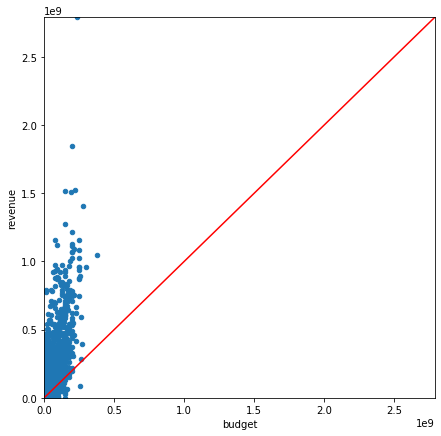

In [49]:
# revenue vs budget
# revenue_v_budget = normalize(movies[["id","revenue","budget"]],["revenue","budget"])
revenue_v_budget = movies[["id","revenue","budget"]]
# revenue_v_budget.head()
chart_1_2 = revenue_v_budget.plot(y="revenue", x="budget"
                       , kind="scatter"
                       , figsize = def_fig_size
                       , xlim=(0,max(revenue_v_budget["revenue"].max(),revenue_v_budget["budget"].max()))
                       , ylim=(0,max(revenue_v_budget["revenue"].max(),revenue_v_budget["budget"].max()))
                          )
l = np.linspace(*chart_1_2.get_xlim())
chart_1_2.plot(l,l,color='r')

### Средний рейтинг и основной (первый) язык фильма
- В данных очень много фильмов с высоким рейтингом и маленьким количеством голосов. Возможно это особенность выборки
- В связи с этим добавлен параметр - минимальное количество голосов (10)
- Также необходимо сравнивать не только рейтинг, но и учитывать количество голосов
- В целом рейтинг фильмов попадает в диапазон от 6 до 7
- Фильмы на английском в среднем имеют рейтинг около 6 и находятся в хвосте рейтинга

Text(0, 0.5, 'average rating')

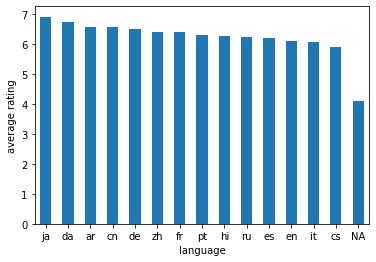

In [54]:
# avg vote vs spoken_language
min_votes_count = 10

vote_v_language = movies[["vote_average","spoken_languages"]].copy()
vote_v_language["first_language"] = vote_v_language["spoken_languages"].apply(lambda x: x[0]["iso_639_1"] if len(x)>0 else "NA")
# print(vote_v_language.head())
grouped = (vote_v_language.groupby("first_language")
            .agg({'vote_average': ['mean', 'count']})
            .sort_values(by = ('vote_average','mean'), ascending = False)
            .reset_index()
          )
# print(grouped)
chart_2 = grouped[(grouped['vote_average']['count']>=min_votes_count)].plot(x="first_language", y=('vote_average','mean')
                        , kind = "bar"
#                         , kind = "barh"
                        , legend = False
                     )
# chart_2.invert_yaxis()
chart_2.set_xlabel('language')
chart_2.set_xticklabels(grouped[(grouped['vote_average']['count']>=min_votes_count)]["first_language"],rotation=0)
chart_2.set_ylabel('average rating')



### Количество голосов и средний рейтинг
- Очень мало голосов
- Только один фильм имеет значительное количество голосов
- Вывод - по этим данным проводить анализ рейтинга не корректно

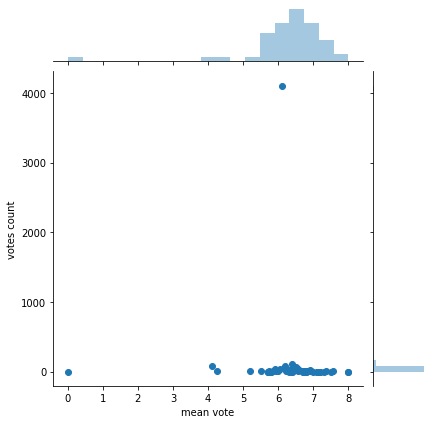

In [58]:
chart_3 = sns.jointplot(x=grouped['vote_average']['mean'],y=grouped['vote_average']['count'])
chart_3.set_axis_labels('mean vote', 'votes count', fontsize=10)

### Ретинг фильмов по дате релиза
- Видно сильный разброс рейтингов в период до 1940
- Далее относительне плато
- За плато следует стабильное снижение рейтинга до уровня 5.5
- В 2019-2020 видим сильный рост рейтингу. Этот момент необходимо изучить отдельно. Вероятно не корректное распределение данных

Text(0, 0.5, 'average rating')

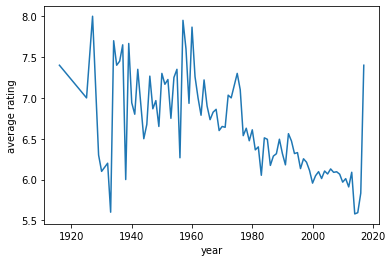

In [8]:
# avg vote vs release date in time
vote_v_year = movies[["vote_average","release_date"]].copy()
vote_v_year["year"] = vote_v_year["release_date"].apply(lambda x: (x.year)).fillna(0).astype(int)
grouped = (vote_v_year[vote_v_year["year"]>0]
        .groupby("year").agg({"vote_average":["mean"]})
        .reset_index()
        .sort_values(by = "year")
        )
chart_4=grouped.plot(x="year", y=('vote_average','mean')
                        , kind = "line"
                        , legend = False
                    )
chart_4.set_ylabel('average rating')

### Имя режиссера и окупаемость
- Фильмы Спилгерба заработали больше всех в прокате
- Лукас и Ван имеют самый большой разброс ROI
- Предваительно, фильмы Скотта, Бартона и Зингера имеют самый маленький разброс ROI
- В целом уровни ROI для топовых режиссером находятся в одном диапазоне, выбиваются всего несколько

[Text(0, 0, 'Steven Spielberg'),
 Text(0, 0, 'Peter Jackson'),
 Text(0, 0, 'James Cameron'),
 Text(0, 0, 'Michael Bay'),
 Text(0, 0, 'Christopher Nolan'),
 Text(0, 0, 'Chris Columbus'),
 Text(0, 0, 'Robert Zemeckis'),
 Text(0, 0, 'George Lucas'),
 Text(0, 0, 'Tim Burton'),
 Text(0, 0, 'Ridley Scott'),
 Text(0, 0, 'Gore Verbinski'),
 Text(0, 0, 'Sam Raimi'),
 Text(0, 0, 'Joss Whedon'),
 Text(0, 0, 'Roland Emmerich'),
 Text(0, 0, 'Francis Lawrence'),
 Text(0, 0, 'Ron Howard'),
 Text(0, 0, 'Bryan Singer'),
 Text(0, 0, 'Sam Mendes'),
 Text(0, 0, 'Andrew Adamson'),
 Text(0, 0, 'Carlos Saldanha'),
 Text(0, 0, 'Clint Eastwood'),
 Text(0, 0, 'Zack Snyder'),
 Text(0, 0, 'M. Night Shyamalan'),
 Text(0, 0, 'Jon Favreau'),
 Text(0, 0, 'James Wan')]

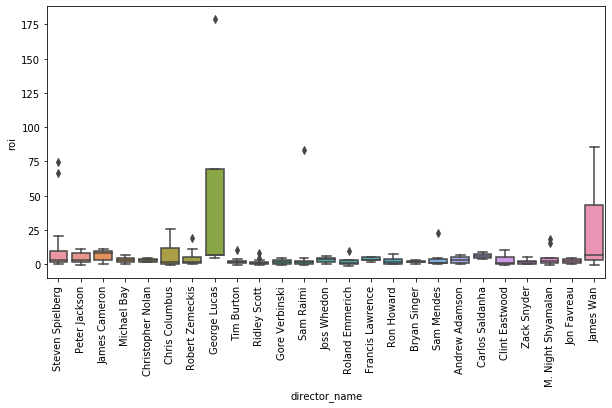

In [59]:
# director vs avg revenue/budget
def calc_roi(row):
    if row["revenue"]!=0 and row["budget"]!=0:
        return row["revenue"]/row["budget"]-1
    return 0

budget_v_revenue = movies[["id","original_title","budget","revenue"]].copy()
budget_v_revenue["roi"] = budget_v_revenue.apply(calc_roi, axis = 1)
df=pd.merge(budget_v_revenue, credits[["movie_id","director_name"]]
                  , left_on = "id"
                  , right_on = "movie_id")
# print(budget_v_revenue["roi"].max())
# print(budget_v_revenue["roi"].min())
top_gross_directors = (df.groupby("director_name").agg({"revenue":["sum"]})
                        .sort_values(by = ("revenue","sum"), ascending = False)
                        .head(25)
                        .index.values
                      )
# print(top_gross_directors)
plt.figure(figsize=(10, 5))
chart_5 = sns.boxplot(x="director_name", y="roi"
                            ,data = df[df["director_name"].isin(top_gross_directors)]
                            ,order = top_gross_directors
                     )

chart_5.set_xticklabels(top_gross_directors,rotation=90)